## Notebook to Replicate Mouse Brain Sagittal Anterior results (Fig S2)
#### Neighborhood preservation
#### Gene expression similarity

---

**Author:** Benedetta Manzato  
**Date:** 30 October 2025

**Download:** (1) https://www.10xgenomics.com/datasets/mouse-brain-serial-section-1-sagittal-anterior-1-standard (2) https://www.10xgenomics.com/datasets/mouse-brain-serial-section-2-sagittal-anterior-1-standard

In [1]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree, distance, KDTree
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import anndata as ad
import scikit_posthocs as sp
import itertools
import scanpy as sc
from collections import Counter

ds = 'Mouse_Brain_Sagittal_Anterior_10X'
wd = f'/exports/humgen/bmanzato/valid_data/{ds}'
benchmark_dir = '/exports/humgen/bmanzato/benchmark'

### Neighborhood preservation

#### Read data (aligned and tile-centroid pre-alignment)

In [2]:
### Read coord final ### ccf_1 is QUERY
ccf_1 = pd.read_csv(f"{wd}/coord_final/coord_final_section1_stack_224.csv",index_col=0)
ccf_2 = pd.read_csv(f"{wd}/coord_final/coord_final_section2_stack_224.csv",index_col=0)

# Read vit coord (tissue centroids + outside)
vit_coord_1 = pd.read_csv(f"{wd}/ViT/ViT_coord_1_224.csv",index_col=0)
vit_coord_2 = pd.read_csv(f"{wd}/ViT/ViT_coord_2_224.csv",index_col=0)

# assign ViT index names to ccf
ccf_1.index = vit_coord_1.index
ccf_2.index = vit_coord_2.index

# filter out "outside" patches
ccf_1 = ccf_1[~ccf_1.index.str.endswith("_outside")]
ccf_2 = ccf_2[~ccf_2.index.str.endswith("_outside")]

ccf_1.columns = ['x_aligned','y_aligned']
ccf_2.columns = ['x_aligned','y_aligned']

# filter out "outside" patches
vit_coord_1 = vit_coord_1[~vit_coord_1.index.str.endswith("_outside")]
vit_coord_2 = vit_coord_2[~vit_coord_2.index.str.endswith("_outside")]

In [3]:
def get_nearest_neighbors(index, k=24):
        distances, indices = tree.query(coords[index], k=k+1)  # k+1 to exclude self
        return indices[1:]  

# apply to query (pre-alignment)
coords = vit_coord_1[['x', 'y']].values
tree = KDTree(coords)
vit_coord_1['neighborhood_before'] = [get_nearest_neighbors(i) for i in range(len(vit_coord_1))]

# apply to query (aligned)
coords = ccf_1[['x_aligned', 'y_aligned']].values
tree = KDTree(coords)
ccf_1['neighborhood_after'] = [get_nearest_neighbors(i) for i in range(len(ccf_1))]

# function to count the number of overlapping neighbors between two lists
def count_overlapping_neighbors(neigh1, neigh2):
    return len(set(neigh1).intersection(neigh2))

# apply
overlap_counts = []
for idx in vit_coord_1.index:
    if idx in ccf_1.index: 
        overlap_count = count_overlapping_neighbors(vit_coord_1.loc[idx, 'neighborhood_before'], ccf_1.loc[idx, 'neighborhood_after'])
        overlap_counts.append(overlap_count)

overlap_counts_series = pd.Series(overlap_counts)

#### Neighborhood preservation barplot

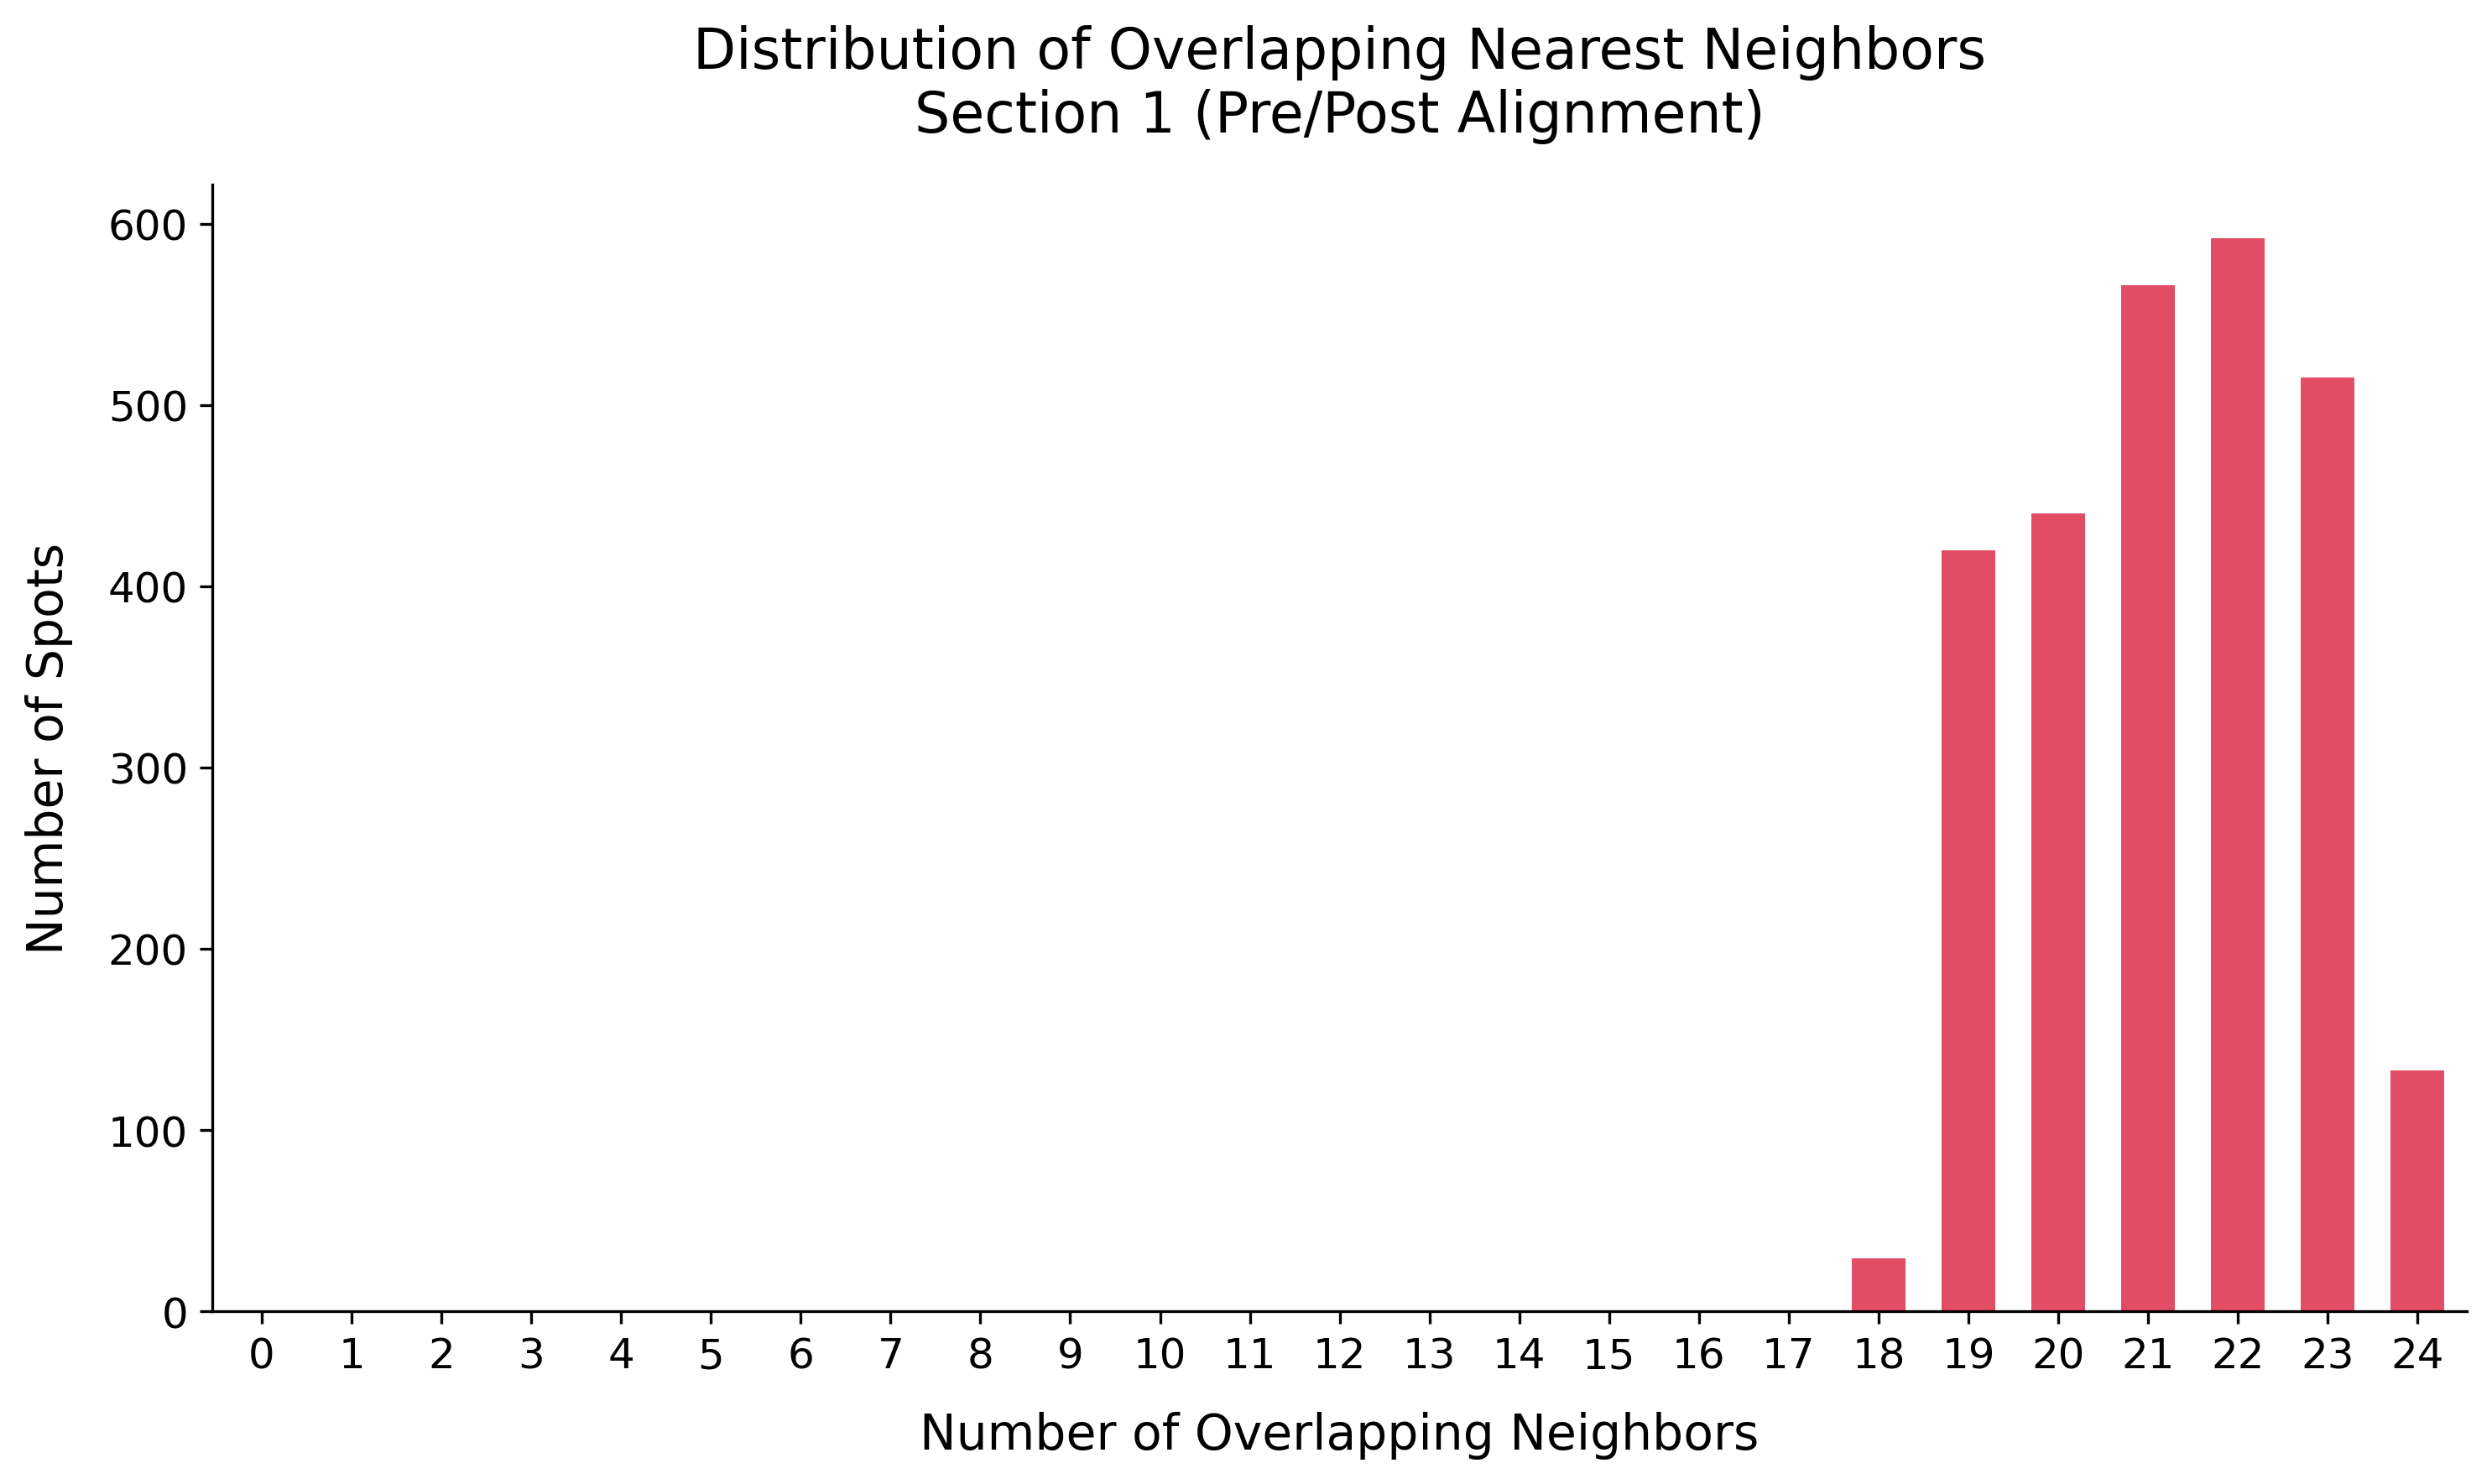

In [4]:
plt.figure(figsize=(10, 6), dpi=300)

full_range = list(range(0, overlap_counts_series.max() + 1))

ax = overlap_counts_series.value_counts().reindex(full_range, fill_value=0).sort_index().plot(
    kind='bar', color='#dd2d4a', width=0.6, alpha=0.85
)

plt.xlabel('Number of Overlapping Neighbors', fontsize=14, labelpad=10)
plt.ylabel('Number of Spots', fontsize=14, labelpad=10)
plt.title('Distribution of Overlapping Nearest Neighbors\nSection 1 (Pre/Post Alignment)', fontsize=16, pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.tight_layout()

plt.show()

### Gene expression similarity

#### Read aligned dataset

In [5]:
multimodal_ds = ad.read_h5ad(f'/exports/humgen/bmanzato/COAST_package/output_anterior/multimodal_anndata/multimodal_dataset.h5ad')

#### Read original count matrices and find HVG

In [8]:
# read
section1_h5 = sc.read_10x_h5(f'{wd}/data/V1_Mouse_Brain_Sagittal_Anterior_raw_feature_bc_matrix.h5')

#add metadata
tissuepos_section1 = pd.read_csv(f'{wd}/data/spatial_section1/tissue_positions_list.csv', index_col=0,header=None)
tissuepos_section1 = tissuepos_section1.sort_index()
section1_h5.obs = pd.concat([section1_h5.obs,tissuepos_section1],axis=1)
section1_h5.obs.columns = ['in_tissue','array_row','array_col','y','x']
section1_h5 = section1_h5[section1_h5.obs['in_tissue']==1]

# hvg
section1_h5.layers["log_transformed"] = np.log1p(section1_h5.X)
section1_h5.X = section1_h5.layers["log_transformed"]
sc.pp.highly_variable_genes(section1_h5)
highly_var_genes = section1_h5.var[section1_h5.var['highly_variable'] == True].index.tolist()

#### Extract HVG from multimodal_ds

In [9]:
# filter to keep HVG
df = multimodal_ds.to_df()  

df1_s1 = df.filter(like='_tissue1').rename(columns=lambda x: x.replace('_tissue1', ''))[highly_var_genes]
df2_s2 = df.filter(like='_tissue2').rename(columns=lambda x: x.replace('_tissue2', ''))[highly_var_genes]

assert df1_s1.shape == df2_s2.shape, "Mismatch in number of rows or columns between s1 and s2 features."

# calculate cosine similarity
cosine_similarities = []
for i in range(df1_s1.shape[0]):
    s1_row = df1_s1.iloc[i].values.reshape(1, -1)
    s2_row = df2_s2.iloc[i].values.reshape(1, -1)
    similarity = cosine_similarity(s1_row, s2_row)[0][0]
    cosine_similarities.append(similarity)

#### Gene expression similarity histogram

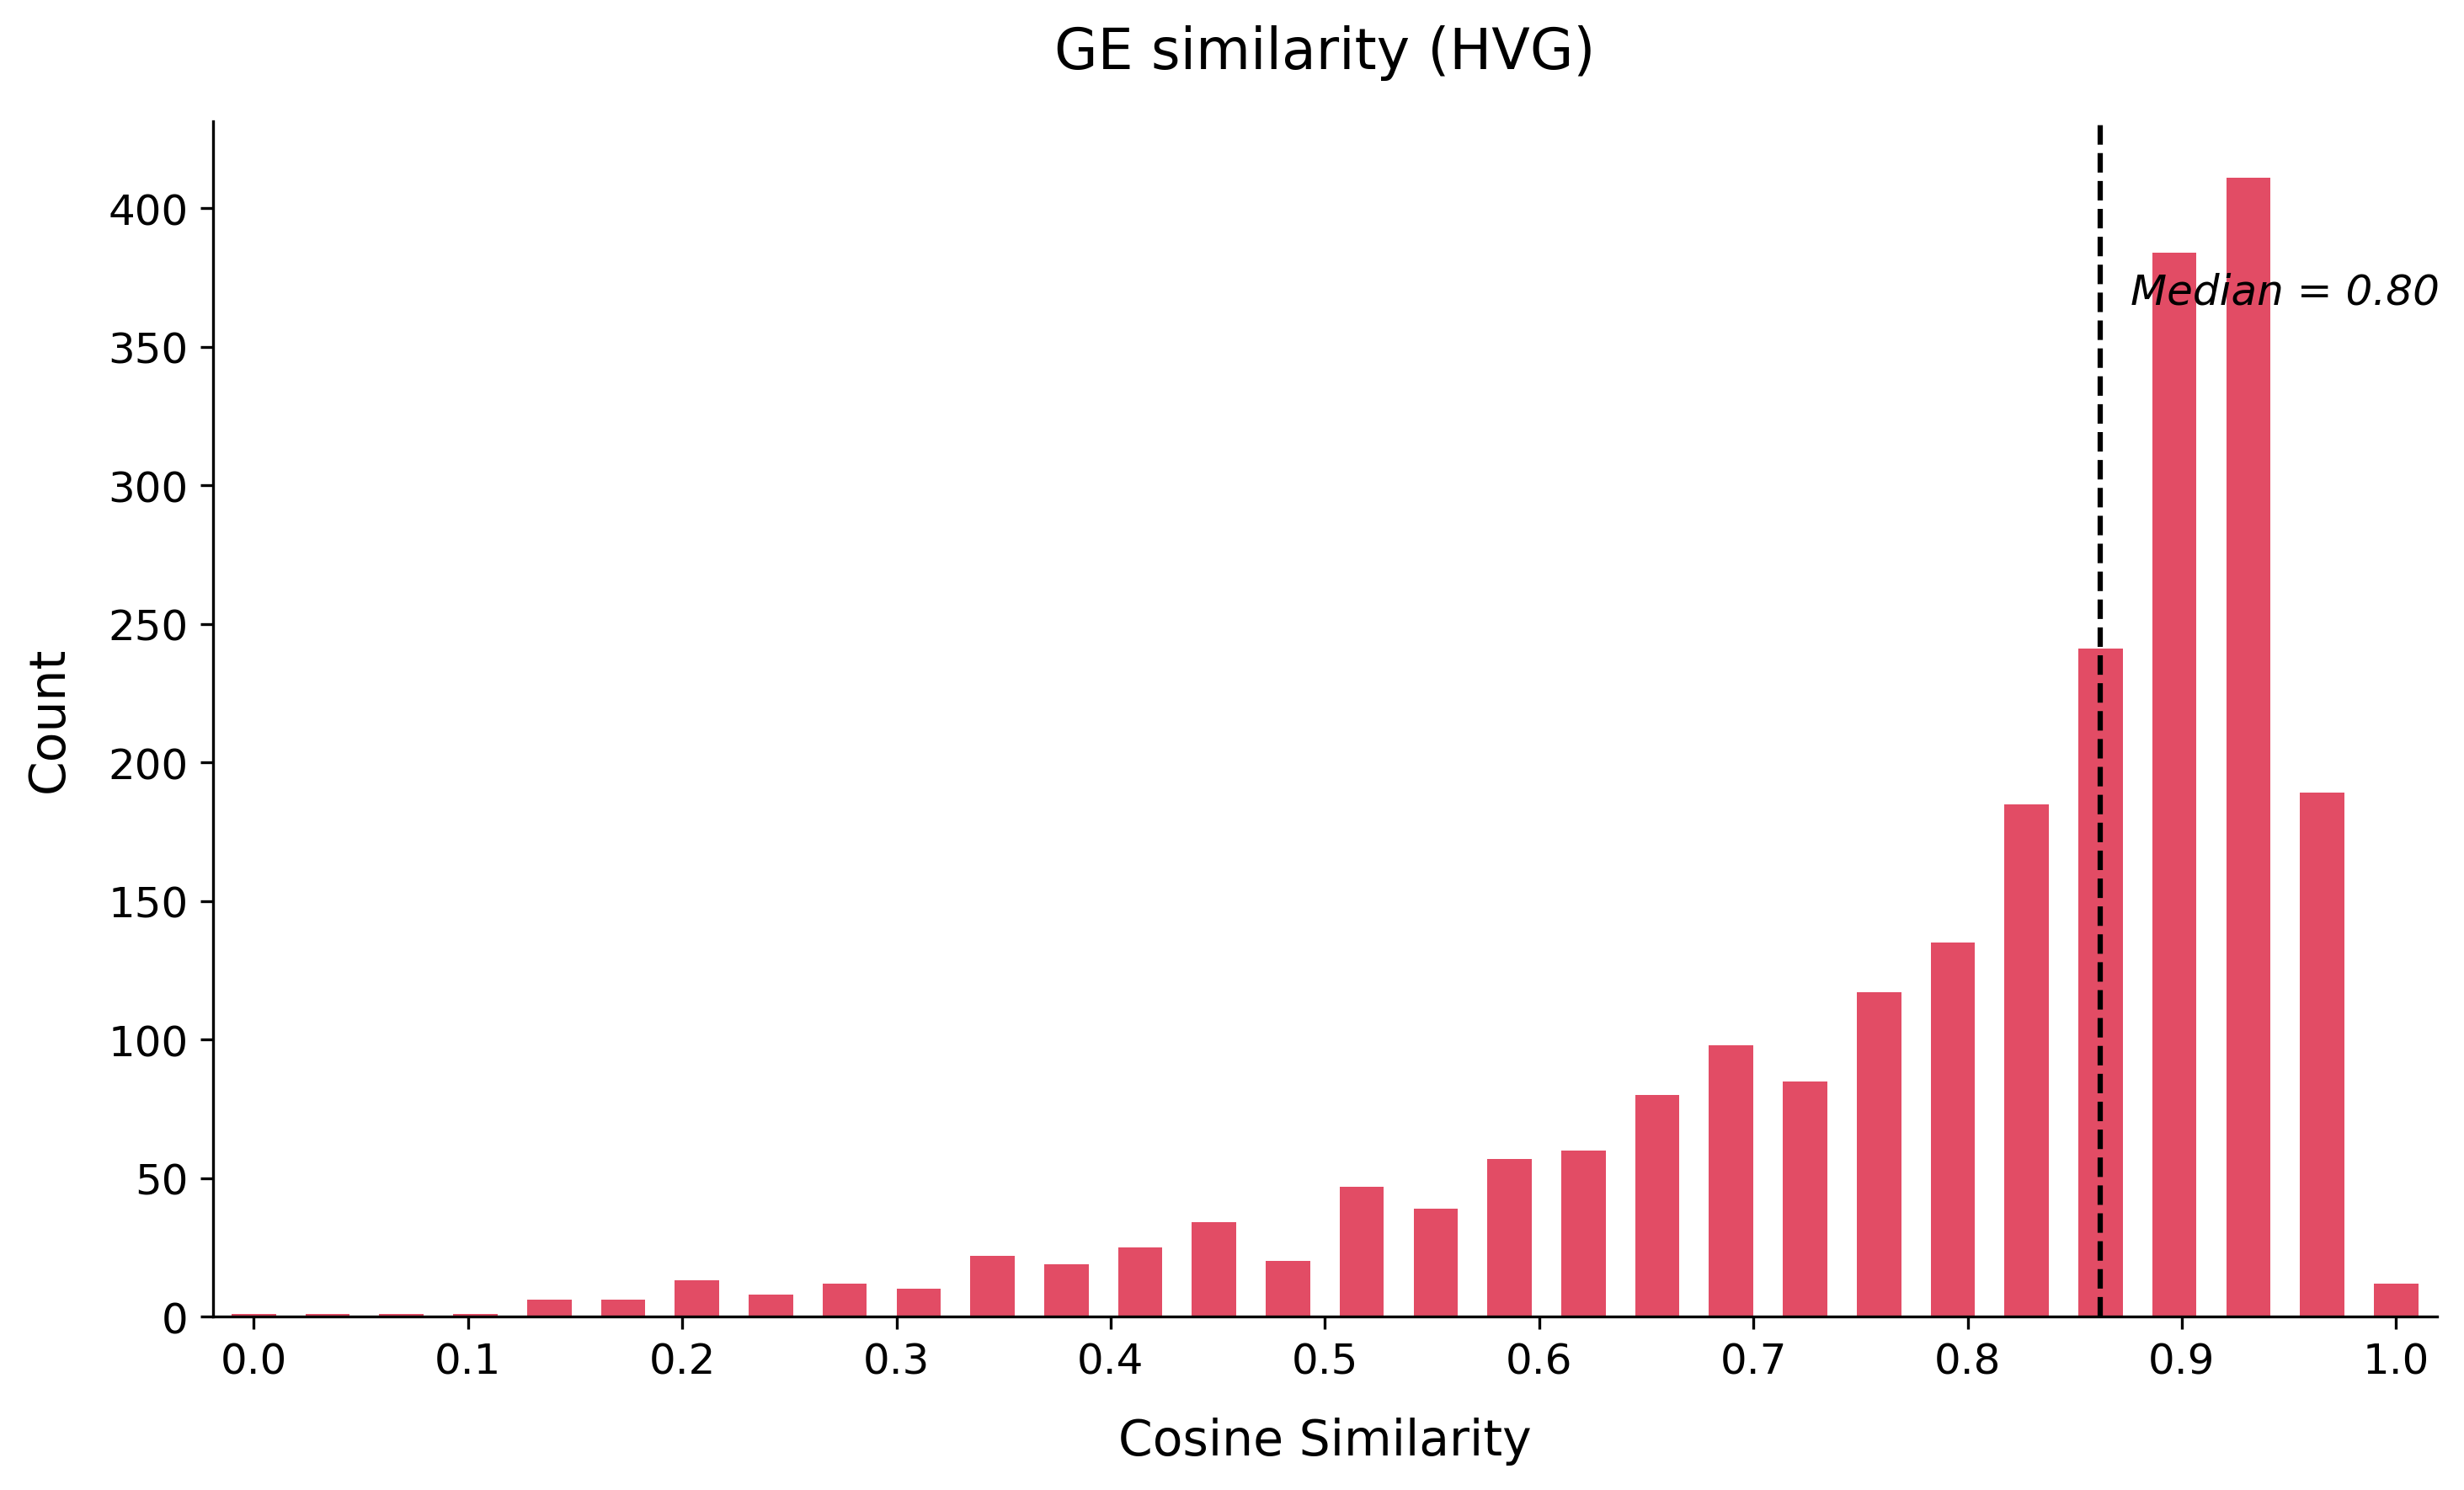

In [10]:
counts, bins = np.histogram(cosine_similarities, bins=30)
centers = 0.5 * (bins[:-1] + bins[1:])
cosine_series = pd.Series(counts, index=centers)
# median
median_val = np.median(cosine_similarities)
bin_idx = np.digitize(median_val, bins) - 1        
bin_idx = np.clip(bin_idx, 0, len(centers)-1)      

plt.figure(figsize=(10, 6), dpi=300)

ax = cosine_series.plot(
    kind='bar',
    color='#dd2d4a',
    width=0.6,
    alpha=0.85
)

plt.xlabel('Cosine Similarity', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.title('GE similarity (HVG)', fontsize=16, pad=15)

plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

plt.axvline(x=bin_idx, color='black', linestyle='--', linewidth=1.5)

plt.text(bin_idx + 0.4, max(counts) * 0.9, f'Median = {median_val:.2f}',
         rotation=0, color='black', fontsize=12, ha='left', va='center', style='italic')

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

xticks = np.arange(0, 1.1, 0.1)
tick_positions = np.linspace(0, len(centers) - 1, len(xticks))  # map 0..1 to 0..n-1
ax.set_xticks(tick_positions)
ax.set_xticklabels([f'{x:.1f}' for x in xticks], rotation=0, fontsize=12)

plt.tight_layout()
plt.show()
